In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import os
import imageio
from tqdm import tqdm

In [2]:
# define control points as below
# It's better to minimize the stretched energy when generating the control points.
# Here I just randomly pick some, so it may not give you a good enough performance.
# We need the wisdom of integration of plan and control [:doge:]

dots = np.vstack([
    [[0, 0] for _ in range(1)],
    [[_, math.cos(_) - 1] for _ in np.linspace(0, 2 * math.pi, 24)],
    [[3*math.cos(_)+2*math.pi, 3*math.sin(_)-3] for _ in np.linspace(math.pi/2, -math.pi/2, 30)], 
    [[_, -0.5*math.cos(_) - 5.5] for _ in np.linspace(2 * math.pi, 0, 20)],
    [[-3*math.cos(_), 3*math.sin(_)-3] for _ in np.linspace(-math.pi/2, math.pi/2, 30)]
])

# dots = np.vstack([
#     [[0, _] for _ in np.linspace(0, 3, 5)],
#     [[2*math.cos(_)+2, 2*math.sin(_)+3] for _ in np.linspace(math.pi, math.pi/2, 5)],
#     [[_, 5] for _ in np.linspace(2, 15, 6)],
#     [[5*math.cos(_)+15, 5*math.sin(_)+10] for _ in np.linspace(-math.pi/2, math.pi, 20)],
#     [[10, _] for _ in np.linspace(10, -10, 5)],
#     [[5*math.cos(_)+15, 5*math.sin(_)-10] for _ in np.linspace(-math.pi, math.pi/2, 15)],
#     [[_, 0.8*math.sin(_*math.pi/5)-5] for _ in np.linspace(15, -15, 30)],
#     [[5*math.cos(_)-15, 5*math.sin(_)-10] for _ in np.linspace(math.pi/2, 2*math.pi, 25)],
#     [[-10, _] for _ in np.linspace(-10, 10, 5)],
#     [[5*math.cos(_)-15, 5*math.sin(_)+10] for _ in np.linspace(0, 3*math.pi/2, 10)],
#     [[_, 5] for _ in np.linspace(-15, -2, 10)],
#     [[2*math.cos(_)-2, 2*math.sin(_)+3] for _ in np.linspace(math.pi/2, 0, 5)],
#     [[0, _] for _ in np.linspace(3, 0, 5)]
# ])

In [3]:
# function for render dots via cubic spline
def draw(dots, color, linestyle, file_dir, idx):
    n = len(dots) - 1
    t1 = np.reshape(np.linspace(0, 1, 1001), [1, 1001])
    t2 = t1 ** 2
    t3 = t1 ** 3
    t0 = np.reshape([1 for _ in range(1001)], [1, 1001])
    tmp = np.zeros((n, n + 1))
    tmp[0, 0] = 2
    tmp[0, 1] = -3
    tmp[0, 2] = 1
    for i in range(1,n-1):
        tmp[i, i] = 1
        tmp[i, i+1] = -2
        tmp[i, i+2] = 1
    tmp[-1, -1] = -1
    tmp[-1, -2] = 1
    A = tmp.dot(dots)
    tmp = np.zeros((n, n + 1))
    tmp[0, 0] = -3
    tmp[0, 1] = 4
    tmp[0, 2]= -1
    for i in range(1,n-1):
        tmp[i, i] = -1
        tmp[i, i+1] = 2
        tmp[i, i+2] = -1
    tmp[-1, -1] = 1
    tmp[-1, -2] = -1
    B = tmp.dot(dots)
    tmp = np.zeros((n, n + 1))
    for i in range(1, n):
        tmp[i, i] = -1
        tmp[i, i+1] = 1
    C = tmp.dot(dots)
    tmp = np.zeros((n, n + 1))
    for i in range(0, n):
        tmp[i, i] = 1
    D = tmp.dot(dots)
    interval = np.array([])
    for i in range(n):
        if len(interval) == 0:
            interval = np.reshape(A[i], [-1, 1]).dot(t3) + \
                    np.reshape(B[i], [-1, 1]).dot(t2) + \
                    np.reshape(C[i], [-1, 1]).dot(t1) + \
                    np.reshape(D[i], [-1, 1]).dot(t0)
        else:
            interval = np.append(interval, (
                np.reshape(A[i], [-1, 1]).dot(t3) + \
                np.reshape(B[i], [-1, 1]).dot(t2) + \
                np.reshape(C[i], [-1, 1]).dot(t1) + \
                np.reshape(D[i], [-1, 1]).dot(t0)
            ), axis=1)
    plt.plot(interval[0], interval[1], color=color, linestyle=linestyle)
    plt.scatter(dots.T[0], dots.T[1], color=color, s=8)
    plt.gca().set_axis_off()
    plt.gca().set_xbound(-3.5, 2*math.pi+3.5)
    plt.gca().set_ybound(-6.5, 0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    if idx > -1:
        plt.savefig(file_dir + str(idx) + '.png')
        plt.gca().cla()

# bicycle kinematic
def kinematic(prev_state, a, delta, n, dt, L):
    state = np.zeros((n+1, 4))
    state[0] = prev_state
    for i in range(0, n):
        state[i+1][3] = state[i][3] + a[i] * dt
        state[i+1][2] = state[i][2] + (state[i][3] + state[i+1][3])/2 * delta[i] / L * dt
        state[i+1][0] = state[i][0] + (state[i][3] * math.cos(state[i][2]) + state[i+1][3] * math.cos(state[i+1][2])) / 2 * dt
        state[i+1][1] = state[i][1] + (state[i][3] * math.sin(state[i][2]) + state[i+1][3] * math.sin(state[i+1][2])) / 2 * dt
    return state[1:]

# loss function that needs to minimize
def f(x, x_ref, y, y_ref, a, a_prev, delta, delta_prev, s_weight=10, a_weight=1, delta_weight=1):
    return np.linalg.norm(x - x_ref) ** 2 * s_weight + \
           np.linalg.norm(y - y_ref) ** 2 * s_weight + \
           np.linalg.norm(a - a_prev) ** 2 * a_weight + \
           np.linalg.norm(delta - delta_prev) ** 2 * delta_weight

# inequality constraint
def h(a, delta, v, a_min=-2, a_max=2, delta_min=-0.8, delta_max=0.8, v_min=-5, v_max=10):
    return np.array([
        a_min - a,
        a - a_max,
        delta_min - delta,
        delta - delta_max,
        v_min - v,
        v - v_max
    ])

# PHR Augmented Lagrangian
def L(prev_state, x_ref, y_ref, a, a_prev, delta, delta_prev, rho, mu, tau, wheel_base, s_weight=10, a_weight=100, delta_weight=1):
    x, y, phi, v = kinematic(prev_state, a, delta, len(a), tau, wheel_base).T
    return f(x, x_ref, y, y_ref, a, a_prev, delta, delta_prev, s_weight, a_weight, delta_weight) + \
           rho / 2 * (np.linalg.norm(np.maximum((h(a, delta, v) + mu / rho), 0)) ** 2)

# numerical gradient
def gradient(prev_state, x_ref, y_ref, a, a_prev, delta, delta_prev, rho, mu, tau, wheel_base, s_weight=10, a_weight=100, delta_weight=1):
    epi = 1e-16
    grad_a = np.zeros(a.shape)
    for i in range(len(a)):
        a_plus = np.copy(a)
        a_plus[i] += epi
        a_minus = np.copy(a)
        a_minus[i] -= epi
        grad_a[i] = (L(prev_state, x_ref, y_ref, a_plus, a_prev, delta, delta_prev, rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight) - \
                     L(prev_state, x_ref, y_ref, a_minus, a_prev, delta, delta_prev, rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)) / (2 * epi)
    grad_delta = np.zeros(delta.shape)
    for i in range(len(delta)):
        delta_plus = np.copy(delta)
        delta_plus[i] += epi
        delta_minus = np.copy(delta)
        delta_minus[i] -= epi
        grad_delta[i] = (L(prev_state, x_ref, y_ref, a, a_prev, delta_plus, delta_prev, rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight) - \
                         L(prev_state, x_ref, y_ref, a, a_prev, delta_minus, delta_prev, rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)) / (2 * epi)
    return np.append(grad_a, grad_delta, axis=0)

(0, 0, 0) 1.3681387855557505
0 0.04804774133235865 0.2949029909160572
(1, 6, 20) 0.05397290576076453
1 0.04966537110298511 0.13183898417423734
2 0.020665540456904687 -0.008673617379884035
3 0.017973555913947673 0.2220446049250313
4 0.02185001311289254 -1.8127860323957634
5 0.030003029076282002 0.40245584642661925
(6, 3, 60) 0.041847181230809494
6 0.03965019728890424 0.49613091412936683
7 0.0443437756551481 0.49613091412936683
8 0.04314290337824423 1.141448047192739
9 0.03490489616857939 -0.006938893903907228
10 0.03167093274246818 -0.9367506770274758
(11, 3, 100) 0.037788678480436856
11 0.03241214599234724 2.8796409701214998
12 0.025027447322622826 -0.26020852139652106
13 0.015671094202866876 0.5603156827405087
14 0.0114100733992861 0.49960036108132044
15 0.011886633911773824 0.4640385298237959
(16, 3, 140) 0.0139396706754749
16 0.013672274213647577 1.078998002057574
17 0.016011573727696512 -1.2264494975156026
18 0.01813656704833855 -0.8482797797526587
19 0.018373874826639963 0.8291978

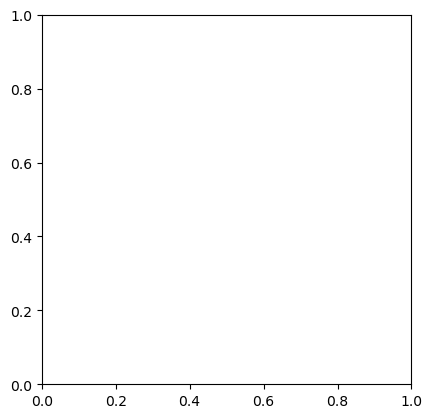

In [4]:
# Hyperparameters
N = 5                      # predict step
tau = 1                    # time constant
epsilon_cons = 1e-3        # constraint criterion
epsilon_prec = 1e-3        # precision criterion
min_xi = 1e-3              # min step precision
beta = 5000                # panalty upper bound
gamma = 5e-1               # penalty increase factor
max_iteration = 150        # max iteration for a single point
s_weight = 1               # weight for control points
a_weight = 2               # weight for acceleration
delta_weight = 3           # weight for steering angle

prev_state = [0, 0, 0, 0]  # x, y, phi, v
prev_input = [0, 0]        # a, delta
wheel_base = 0.005         # wheel base
input = np.zeros(N * 2)
states = [
  np.array(prev_state) for _ in range(3)
]                          # states, repeating stack for rendering better
inputs = []                # inputs
predict = 0
full_dir = 'output/full/'
brief_dir = 'output/brief/'

for idx in range(len(dots)):
    # param
    rho = 1
    xi = 5e-1
    mu = 1

    # reference
    x_ref = dots[idx:idx+N, 0]
    y_ref = dots[idx:idx+N, 1]
    n = len(x_ref)
    while n < N:
        x_ref = np.append(x_ref, x_ref[-1])
        y_ref = np.append(y_ref, y_ref[-1])
        n += 1

    # PHR
    for iter in range(max_iteration):
        loss = L(prev_state, x_ref, y_ref, input[:n], np.append(prev_input[0], input[:n-1]), input[n:], np.append(prev_input[1], input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)
        grad = gradient(prev_state, x_ref, y_ref, input[:n], np.append(prev_input[0], input[:n-1]), input[n:], np.append(prev_input[1], input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)

        if predict % 20 == 0:
            draw(dots, 'red', '-', '', -1)
            draw(np.array(states), 'blue', '-', '' , -1)
            draw(np.vstack([prev_state, kinematic(prev_state, input[:n], input[n:], n, tau, wheel_base)]), 'lightgreen', '--', full_dir, predict)
            print((idx, iter, predict), loss)
        predict += 1

        # LBFGS
        B = np.identity(n * 2)
        last_grad = grad
        last_loss = 0x3f3f3f3f
        while np.linalg.norm(grad) > xi and last_loss - loss > xi:
            direction = -B.dot(grad)
            rbound = 0x3f3f3f3f if idx == 0 else 10
            l, r, alpha = 0, rbound, 1

            # Lewis-overton line search
            for _ in range(1000):
                new_input = input + alpha * direction
                new_loss = L(prev_state, x_ref, y_ref, new_input[:n], np.append(prev_input[0], new_input[:n-1]), new_input[n:], np.append(prev_input[1], new_input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)
                new_grad = gradient(prev_state, x_ref, y_ref, new_input[:n], np.append(prev_input[0], new_input[:n-1]), new_input[n:], np.append(prev_input[1], new_input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)
                if loss < new_loss - 1e-4 * alpha * grad.dot(direction):
                    r = alpha
                elif new_grad.dot(direction) < 0.95 * grad.dot(direction):
                    l = alpha
                else:
                    break

                if r < rbound:
                    alpha = (l + r) / 2
                else:
                    alpha = 2 * l

            # update parameters
            delta_x = new_input - input
            delta_g = gradient(prev_state, x_ref, y_ref, new_input[:n], np.append(prev_input[0], new_input[:n-1]), new_input[n:], np.append(prev_input[1], new_input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight) - grad

            # cautious
            if delta_g.T.dot(delta_x) > 1e-6 * np.linalg.norm(grad) * input.T.dot(input):
                B = (np.identity(2*n)-delta_x.dot(delta_g.T) / delta_g.T.dot(delta_x)).dot(B).dot(np.identity(2*n)-delta_g.dot(delta_x.T) / delta_g.T.dot(delta_x)) + delta_x.dot(delta_x.T) / delta_g.T.dot(delta_x)

            input = new_input
            last_loss = loss
            loss = L(prev_state, x_ref, y_ref, input[:n], np.append(prev_input[0], input[:n-1]), input[n:], np.append(prev_input[1], input[n:2 * n-1]), rho, mu, tau, wheel_base, s_weight, a_weight, delta_weight)
            grad = grad + delta_g

        # update PHR parameters
        state = kinematic(prev_state, input[:n], input[n:], n, tau, wheel_base)
        mu = np.max(np.maximum(mu + rho * h(input[:n], input[n:], state[:,3]), 0))
        rho = np.minimum(rho * (1 + gamma), beta)
        xi = min(min_xi,xi * 0.9)

        # specific boundary
        if loss < 5e-2 and iter > 5:
            break

        last_grad = grad

    prev_input = [input[0], input[N]]
    prev_state = state[0]
    states.append(prev_state)
    inputs.append(prev_input)

    # initialize the input 0,1,...,n-2,n,n+1,2n-2
    # with last input 1,2,...,n-1,n+1,n+2,...,2n-1
    # rather than randomly assigned them to be 0
    input[:N-1]=input[1:N]
    input[N:2*N-1]=input[N+1:2*N]
    input[N-1]=0
    input[2*N-1]=0

    # render and print
    draw(dots, 'red', '-', '', -1)
    draw(np.array(states), 'blue', '-', '' , -1)
    draw(np.array(state), 'green', '--', brief_dir, idx)
    draw(dots, 'red', '-', '', -1)
    draw(np.array(states), 'blue', '-', '' , -1)
    draw(np.array(state), 'green', '--', full_dir, predict)
    predict += 1
    print(idx, loss, grad.mean())

In [5]:
path = full_dir
if path[-1] == '/':
    path = path[:-1]
fps = 60
files = [os.path.join(path, f) for f in os.listdir(path)]
files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
frames = []

for f in tqdm(files):
    img = imageio.imread(f) # RGB格式的array
    img = cv2.resize(img, (640, 480))   # Resize to (640, 480)
    frames.append(img)
imageio.mimsave(path+'.gif', frames, duration=1/fps)

  0%|          | 0/168 [00:00<?, ?it/s]C:\Users\21256\AppData\Local\Temp\ipykernel_2448\3571911777.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f) # RGB格式的array
100%|██████████| 168/168 [00:01<00:00, 123.13it/s]
